Comparing distributions is a common problem whenever we are dealing with approximation problems.
The 'Prior Network's approach' is to use a Neural Network to parametrize a Dirichlet distribution (upon which predictions will be made). 

In our settings we consider $x \in \mathbb{R}^2$. The prior network models $p(\mu|x, \theta)=Dir(\mu|\alpha) \,, \alpha=f(x,\theta))$, where $\alpha$ models the parameters of the network. 


Ideally, we would like the conditional distribution $\mu|x \sim D(f(x;\theta)$ to be a faithful approximation of the target Dirichlet $D(\hat{\alpha}_x)$ where $\hat{\alpha}_x$ denotes the "true Dirichlet" or "target Dirichlet". 


What is a faithful approximation? Oftentimes, one would like to define a distance to compare two elements from a metric space. This is often trivial in a simple euclidian space $\mathbb{R}^p$, where distances are all equivalent.
When it comes to probability distributions, there is no clear choice of "distance " and one option is to use the Kullback-Leibler divergence ($DKL(p,q)=\int p\cdot log(\frac{p}{q})$). Let $p$ be the target distribution (the one to approximate) and $q$ the approximation (i.e variational, or in our case, the distribution parametrized by the prior Network). 

However, in general, $KL(p,q) \neq KL(q,p)$: the "_Forward KL divergence (denoted by KL from now on)_" and "_Reverse KL divergence (RKL)_" might differ. Depending on the distributions considered (in our case, distributions conditioned on the data-henceforth depending on the data), choosing either one might yield different results. 

Therefore, in line with Andrey Malinin's theory, we show that training a prior network using _forward_ or _reverse_ Kullback-Leibler Divergence will, under certain circumstances, yield different results.

### Experimental setup
* For each experiment conducted, the network is trained for a number of epochs ```n_epochs``` and using either the forward or the reverse KL divergence (```reverse```) described earlier.
* The original data set is displayed, as well as the training loss and the decison surface.

In the following section **I**, the following figures are added:
* **Plot of the network's output during the training process**: each training point is a tuple $\{x, \hat{\alpha}_x \}$ where $\hat{\alpha}$ is in the set $\{target_1, target_2, target_3 \} = \{(101, 1, 1), (1, 101, 1), (1, 1, 101) \}$. For all the training points such that $\hat{\alpha}_x \subset \{target_i\} \,,i=\{1,2,3\}$, we display (in column $i$) the three output coordinates of the network during the training curriculum. For instance, the second column-third row corresponds to the evolution of the third coordinates of the network's output $f(x;\theta)_3$ for the training points such that $\hat{\alpha}_x \subset \{target_2\}$.
* **Histogram of the network's output distribution**: once the model is trained, we consider all the points in the dataset and the corresponding network output $f(x;\theta)$. Similarly, column i-row j correspond to the distribution (histogram plot) of $f(x;\theta)_j$ for the points $x$ for which $\hat{\alpha}_x \subset \{target_i\}$.
* **The precision parameter of the network** ( $\sum_i f(x;\theta)_i$ ) during the training curriculum.


In [1]:
#Load the setup
import matplotlib.pyplot as plt
%run -i 'exp_alphas_2.py'
#args.renderer='chrome' #uncomment for interactive plots. Other choices as well.

Loaded the experimental setup


# I - When the data presents well separated clusters, Forward or Reverse objectives yield similar results

In the first place, let's train the prior network on a simple objective: a dataset presenting three distinct clusters, and no OOD points.

We show and interpret the results:
* when the forward kl is used first 
* when the reverse kl is used then

### 1-Well clustered data, forward kl objective

Using the forward KL objective
Training for 1000 epochs


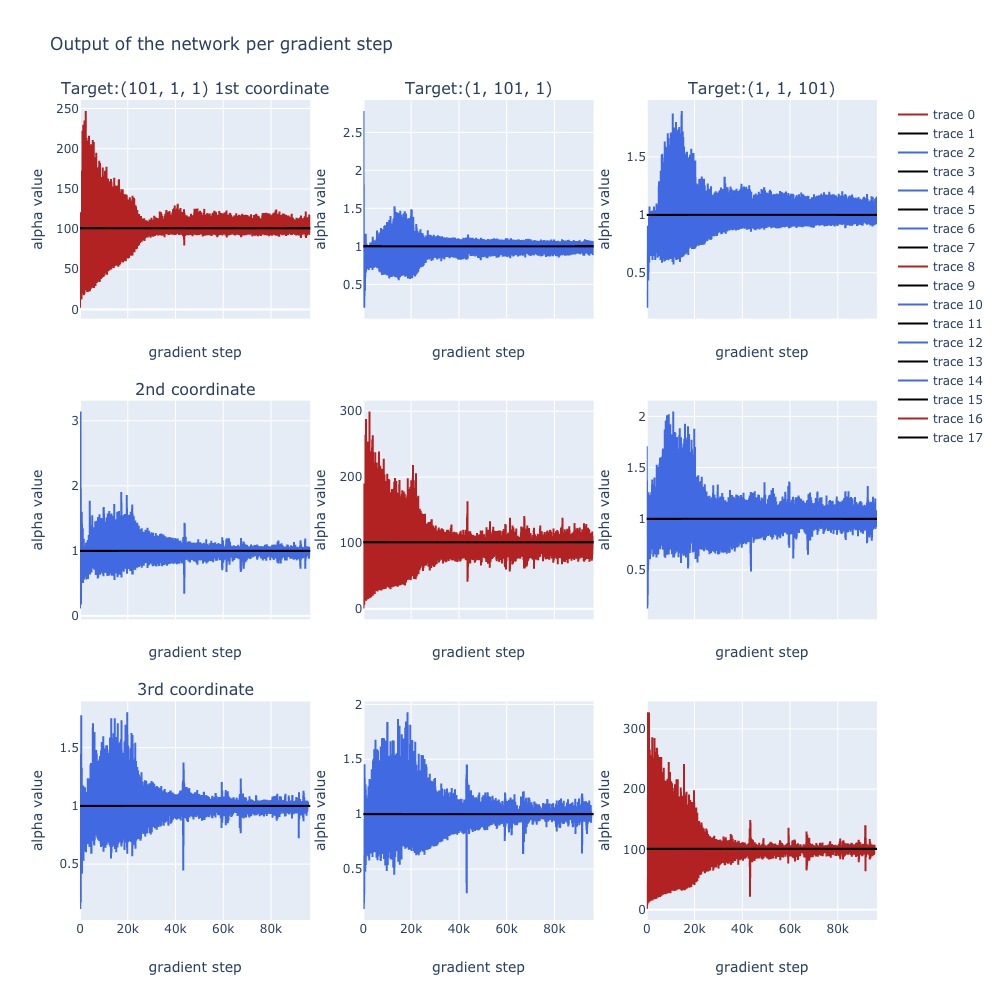

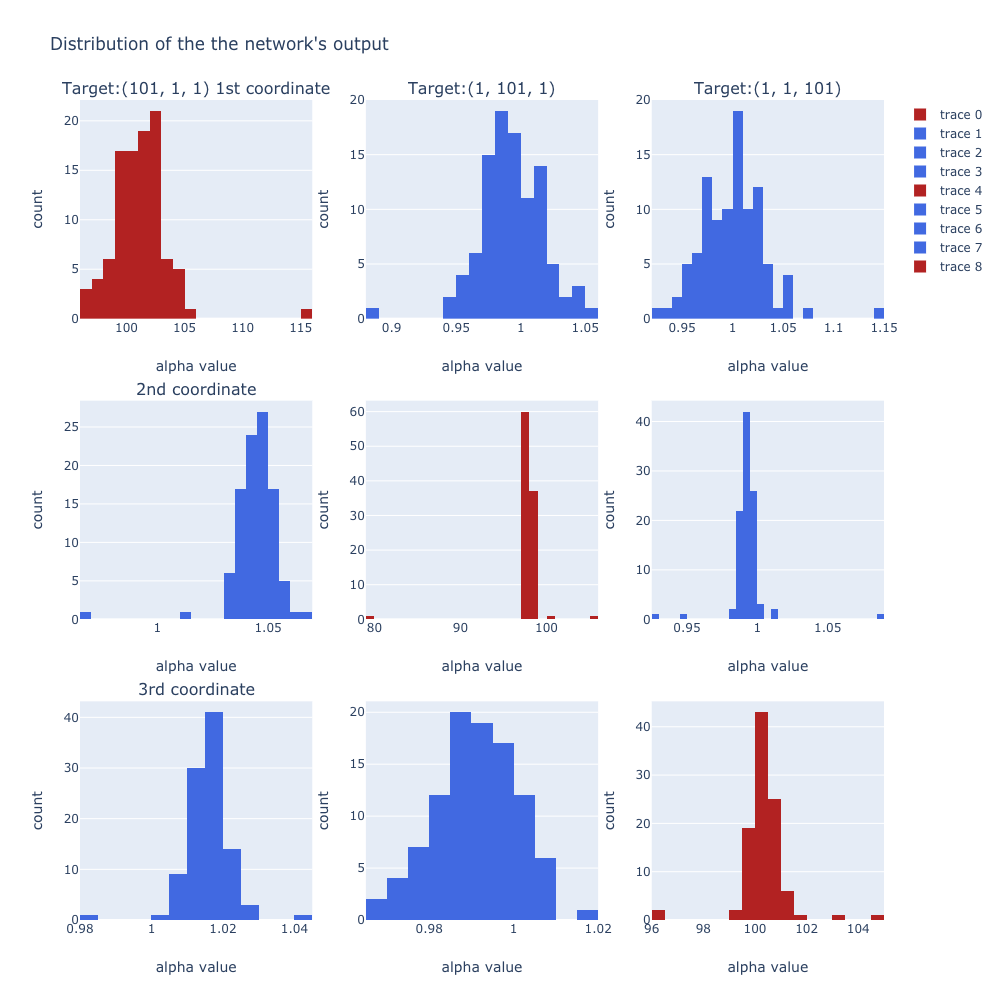

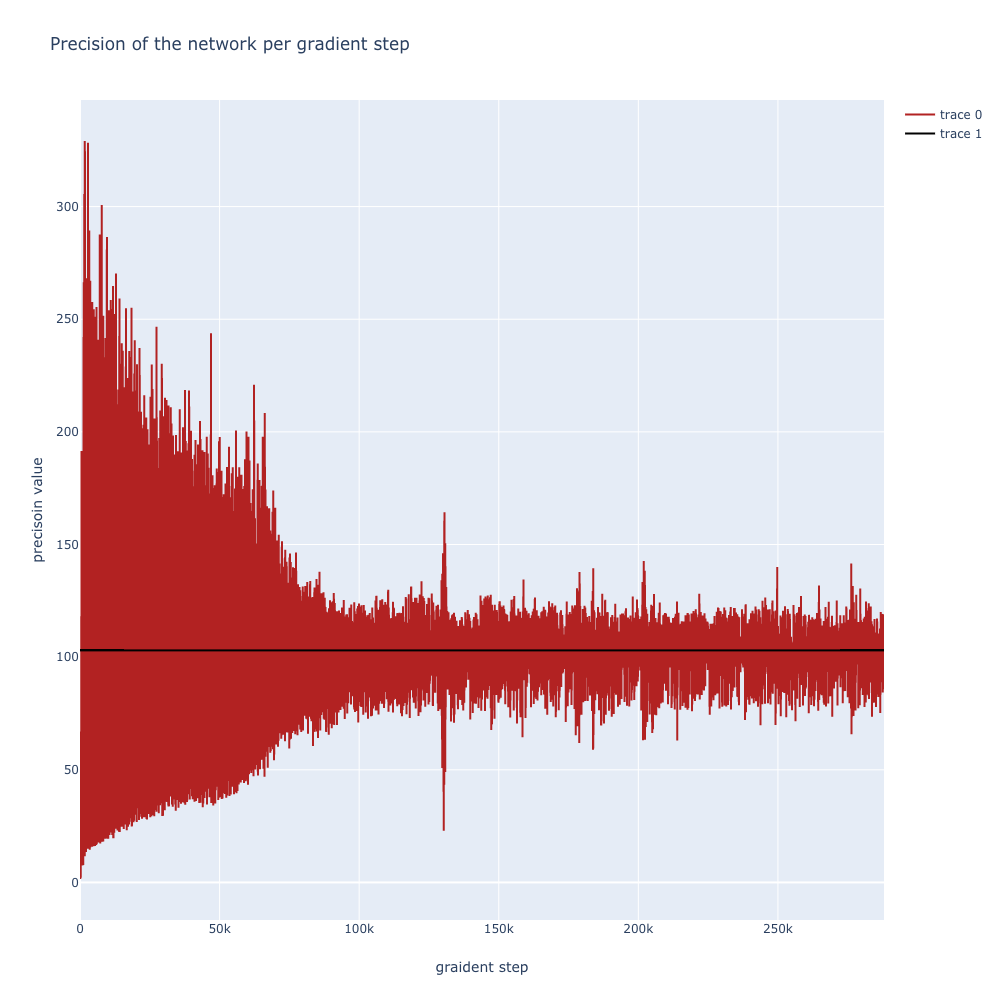

In [5]:
args.n_epochs = 1000
args.reverse = False
#Output: trained model and a dictionnary containing variables saved during the training
model, tracks = main(args, data)

Using the reverse KL objective
Training for 1000 epochs


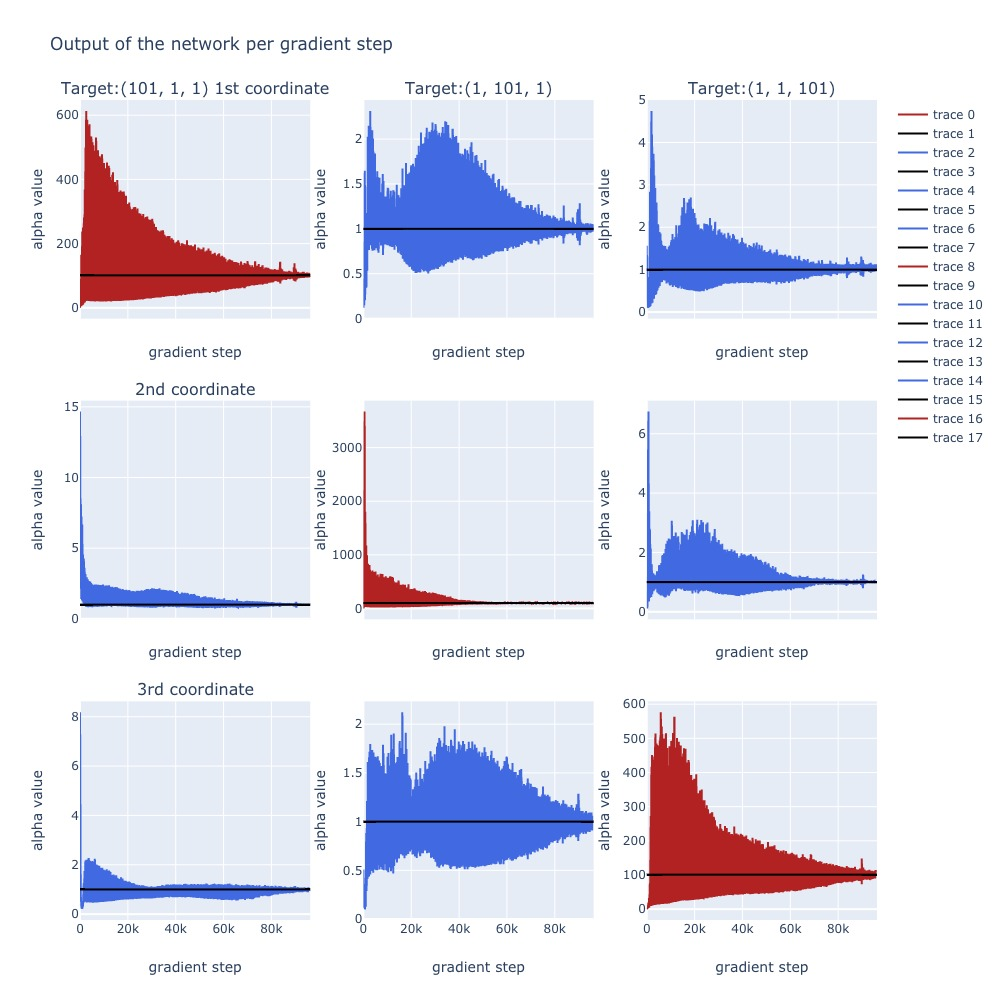

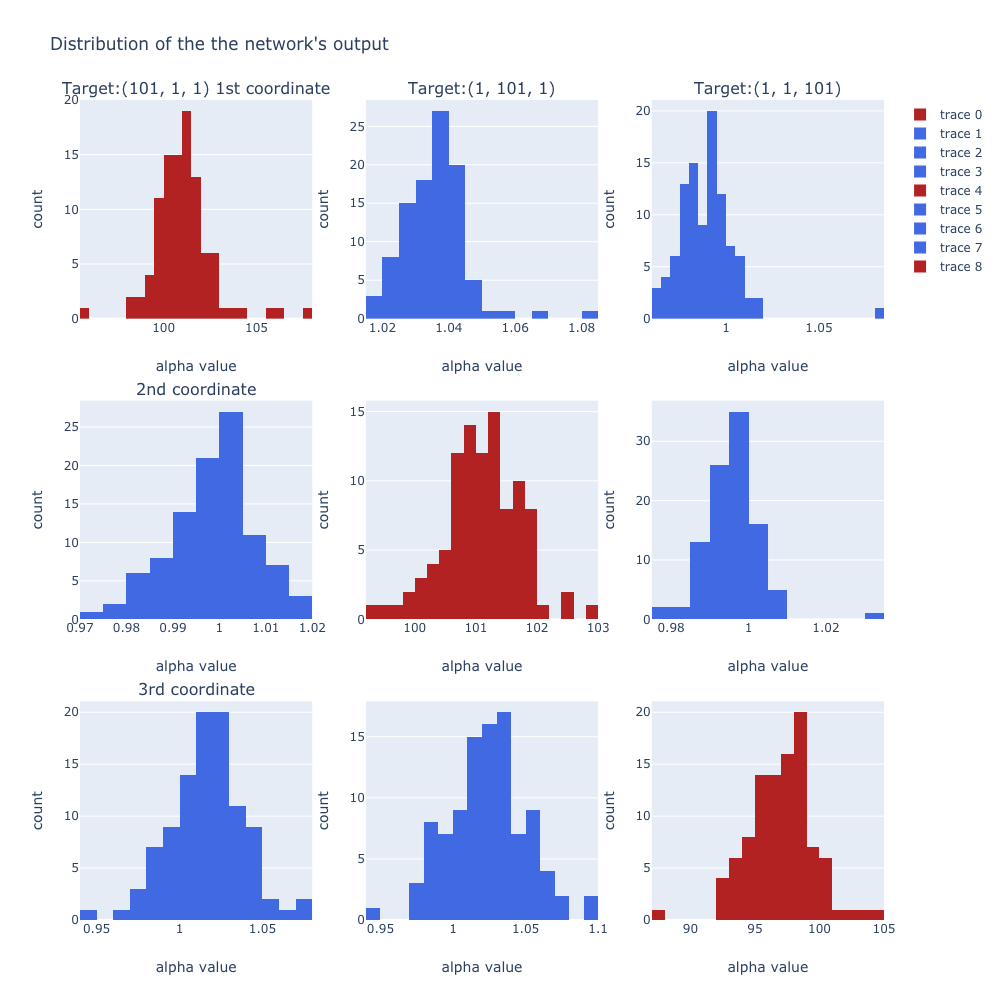

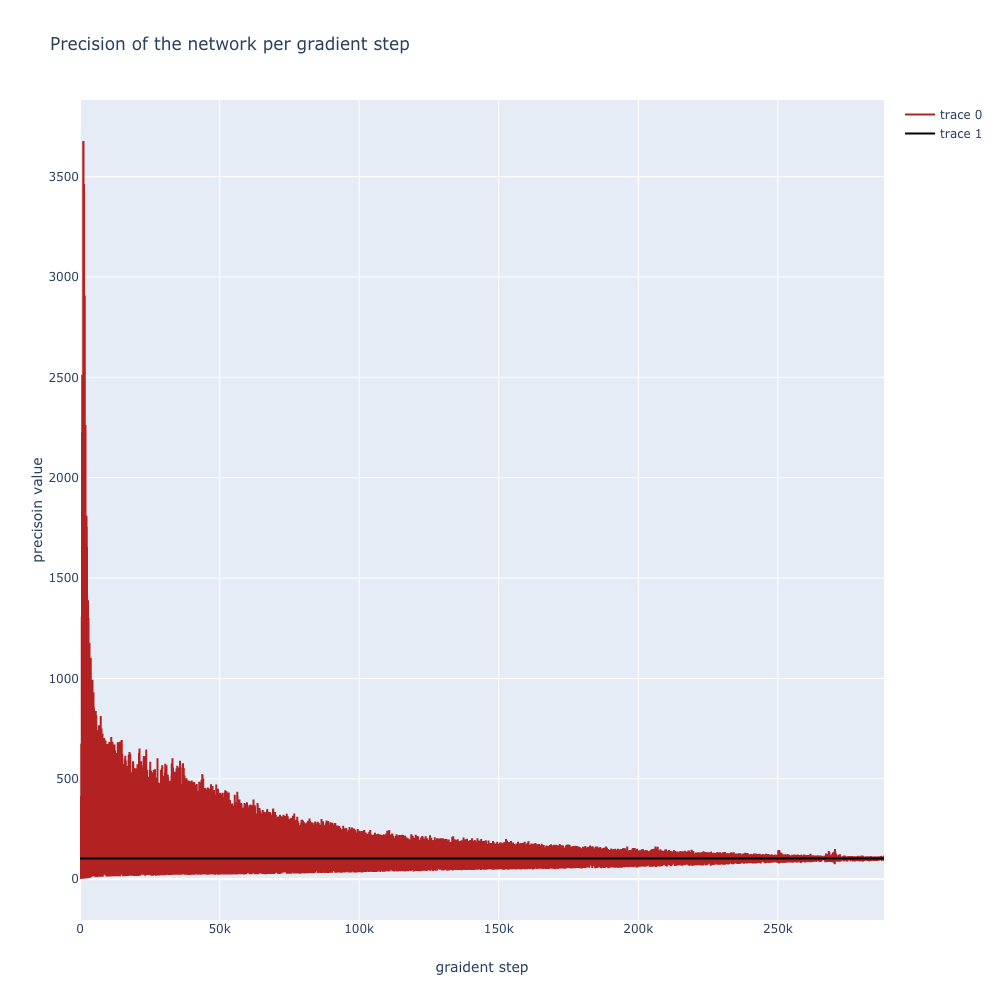

In [6]:
args.n_epochs = 1000
args.reverse = True
model, tracks = main(args, data)

Both training objectives enable the network to capture the structure of the target Dirichlet distribution (or equivalently its concentration parameters). We visually observe a coordinate-wise convergence towards the desired targets (_output of the network per gradient step_). The distribution modelled by the (trained) network centers aroud the desired target values (_histograms_).

We could also note the fact that the reverse kl objective results in a smoother training: the training loss appears to converge faster, the different coordnates of $f(x;\theta)$ seem less volatile and so does the precision of the network. 

Ultimately, we can conclude that despite slight differences, the two training processes yield similar results for the simple settings considered: **data points from distinct classes and strictly not overlapping**.

In [12]:
"""
Discussion about fast/not fast? 
args.n_epochs = 100
args.reverse=False
#args.lr=0.001
#import time 
#beg = time.time()
#main(args, data)
#print('Run in', time.time()-beg)
args.n_epochs = 1000
import time 
beg = time.time()
main(args, data)
print('Run in', time.time()-beg)
"""
print("Discussion about fast/not fast?")

Discussion about fast/not fast?


## II - Class overlap (and high data uncertainty) show that the different training objectives result in different distributions

Using Andrey Malinin's words in _Reverse KL-Divergence Training of Prior Networks:
Improved Uncertainty and Adversarial Robustness_ [(arxiv)](https://arxiv.org/pdf/1905.13472.pdf):
>"the forward KL-divergence (KL) is an inappropriate optimization criterion and instead propose to train Prior Networks with the reverse KL-divergence (RKL)". 

Whenever a prior network is used with overlapping data (id est a dataset presenting an area in which there is no clear dominating class), the KL objective trains the network to behave like an arithmetic mixture of Dirichlet distributions which yields undesirable behaviors, whereas the RKL objective urges the network to behave like a geometric mixture of Dirichlet-inducing a more suitable behavior (see below):

In the following, we:
* Create a new synthetic data set with overlapping classes (and no OOD data)
* Train two networks with the exact same configuration except from the training objective and observe the training curriculum
* We then extend the theoretical reasons why the RKL is more appropriate than the KL objective and experimentally verify the theory advanced

**Remark:**
* In the following we interchangeably use "Reverse Network", "Network trained with the RKL objective", "Forward model" and similarly for "Forward network".

## 1. Training diagnostic

In [54]:
from utils_data import create_data
from utils_run import plot_training_data
#Let's change the data so that the overlap is more important. 
scale = 1.
overlap = mog_three_in_distribution = {
    'gaussians_means': scale * np.array([
        [0., 2.],
        [-np.sqrt(3), -1.],
        [np.sqrt(3), -1.]]),
    'gaussians_covariances': np.array([
        [[2.0, 0], [0, 2.0]],
        [[2.0, 0], [0, 2.0]],
        [[2.0, 0], [0, 2.0]],
    ]),
    'n_samples_per_gaussian': np.array(
        [100, 100, 100]),
    'out_of_distribution': np.array(
        [False, False, False])
}
shuffle = True 
data = create_data([
    create_data_mixture_of_gaussians],
    [mog_three_in_distribution], shuffle=shuffle)

plot_training_data(data['samples'], data['targets'])

Using the forward KL objective
Training for 1000 epochs


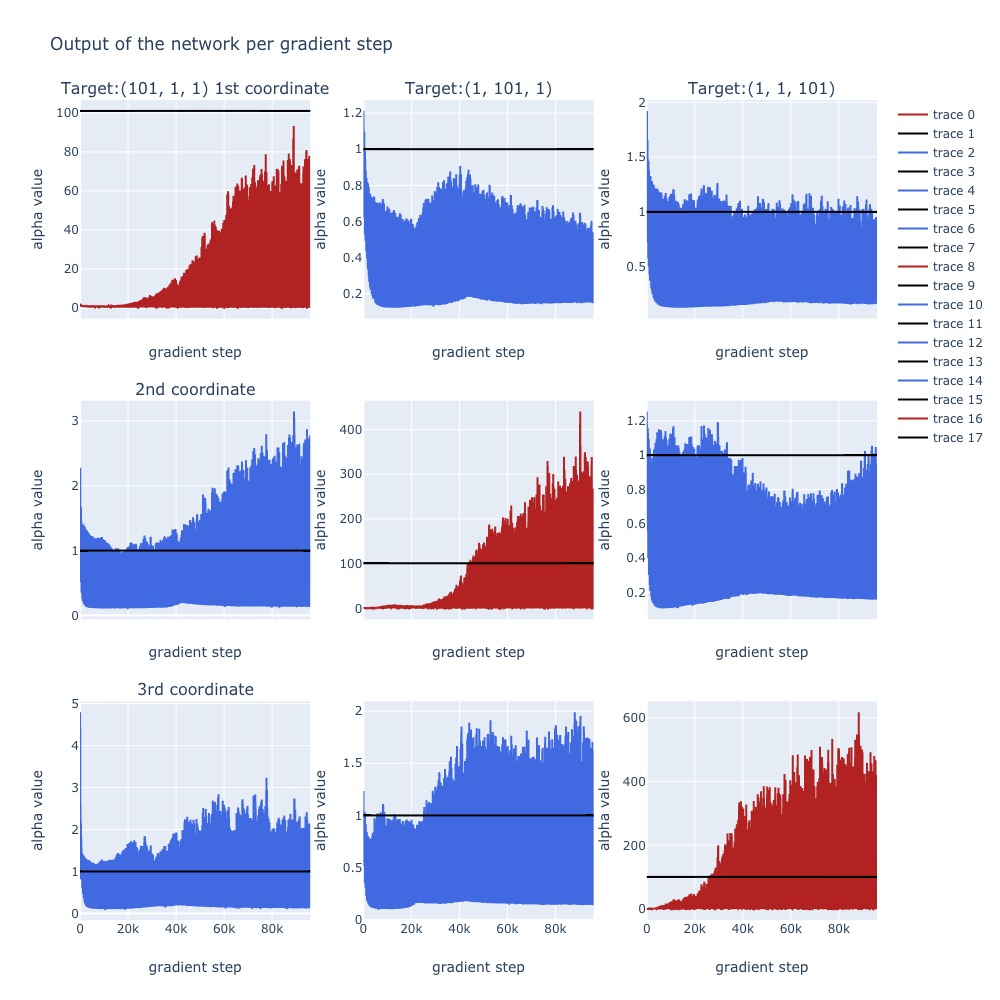

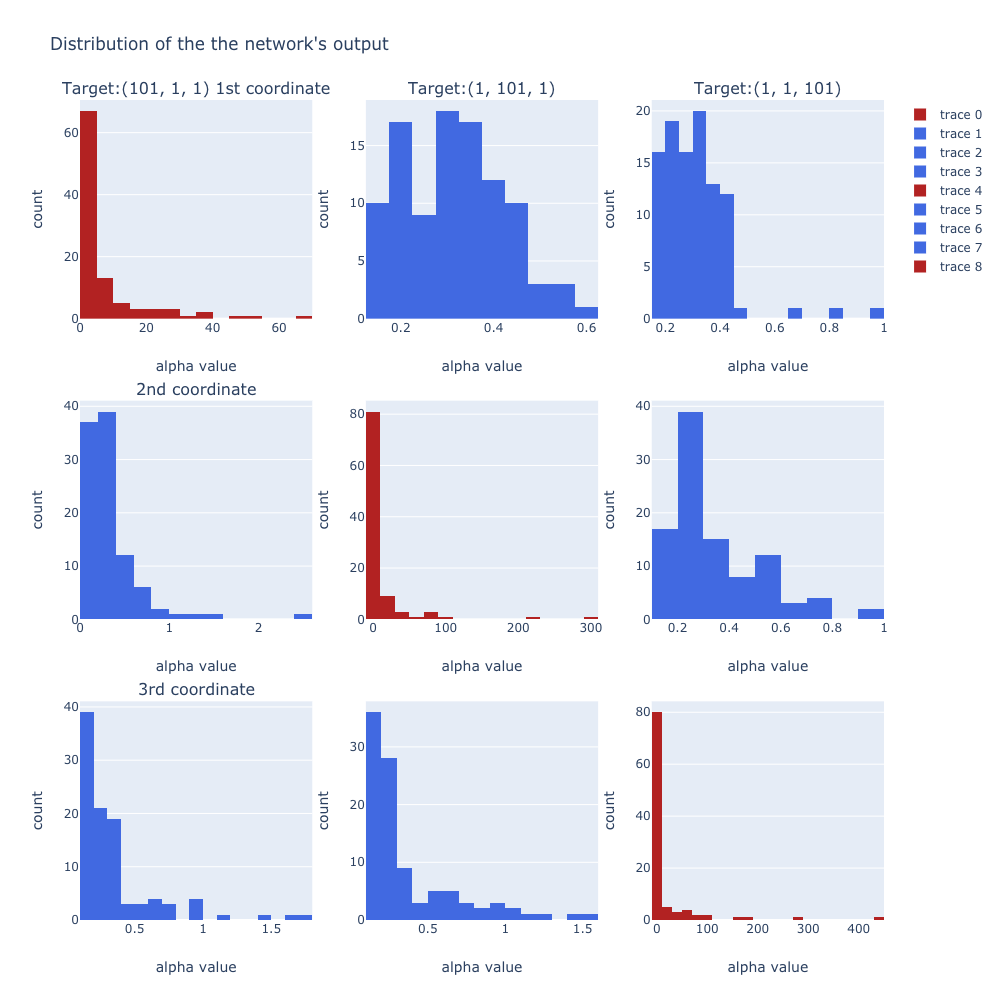

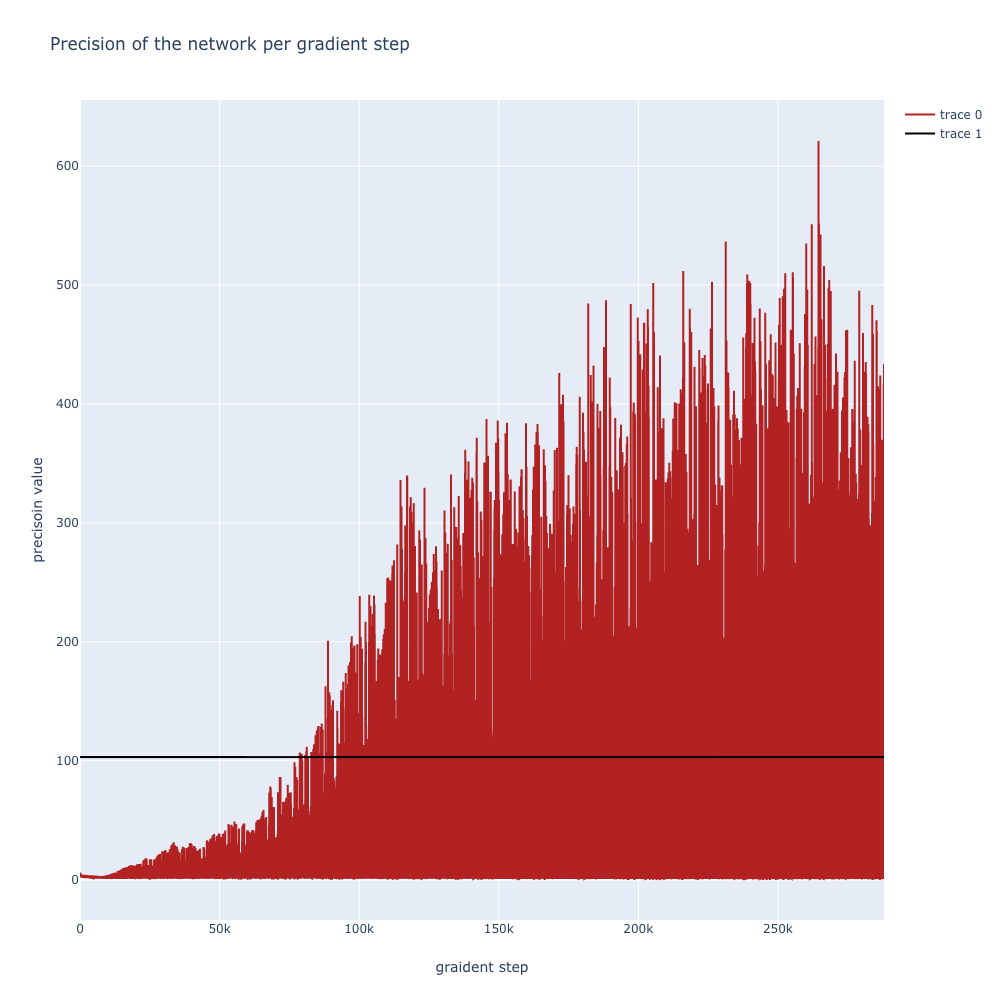

In [55]:
args.n_epochs= 1000
args.reverse = False
#print(args)
model_fwd, tracks_fwd = main(args, data)

Namespace(batch_size=32, dropout_p=0.0, epsilon=0.1, lr=0.001, n_epochs=1000, reverse=True, scale=10.0, track_mode=True, verbose=False)
Using the reverse KL objective
Training for 1000 epochs


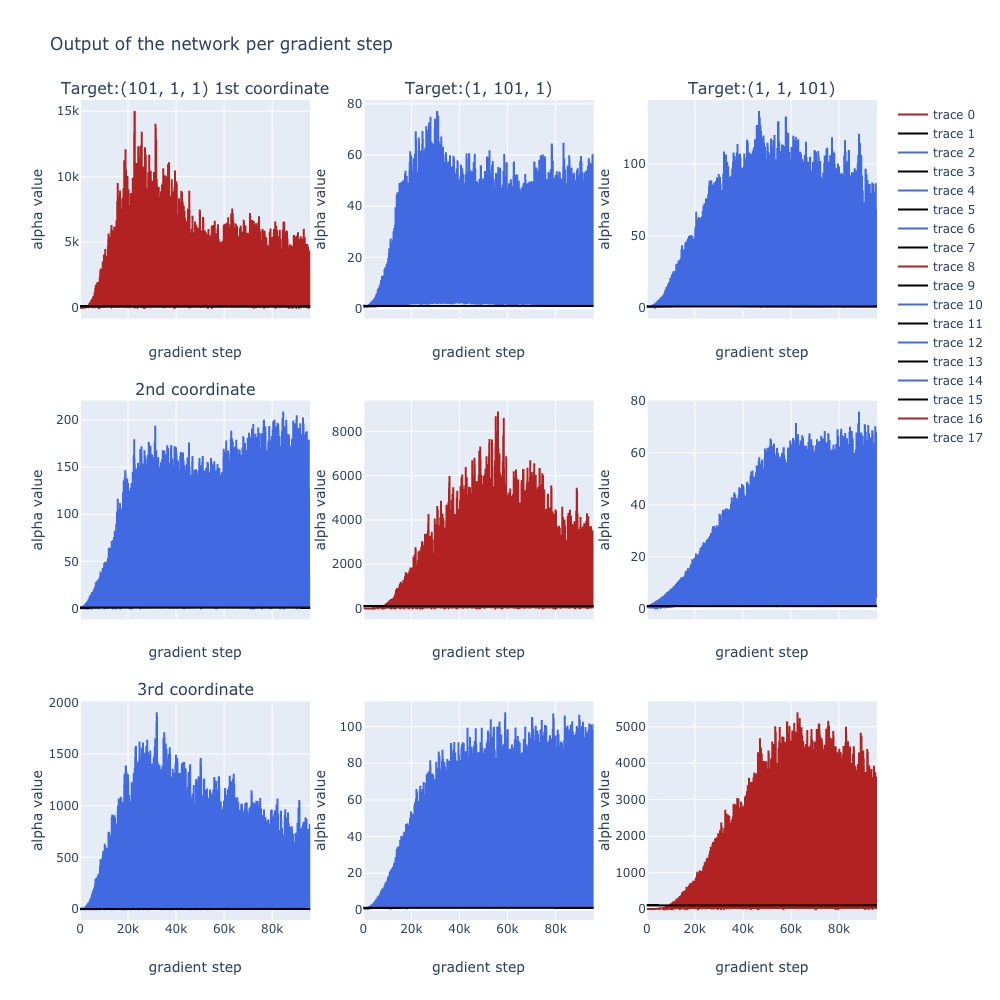

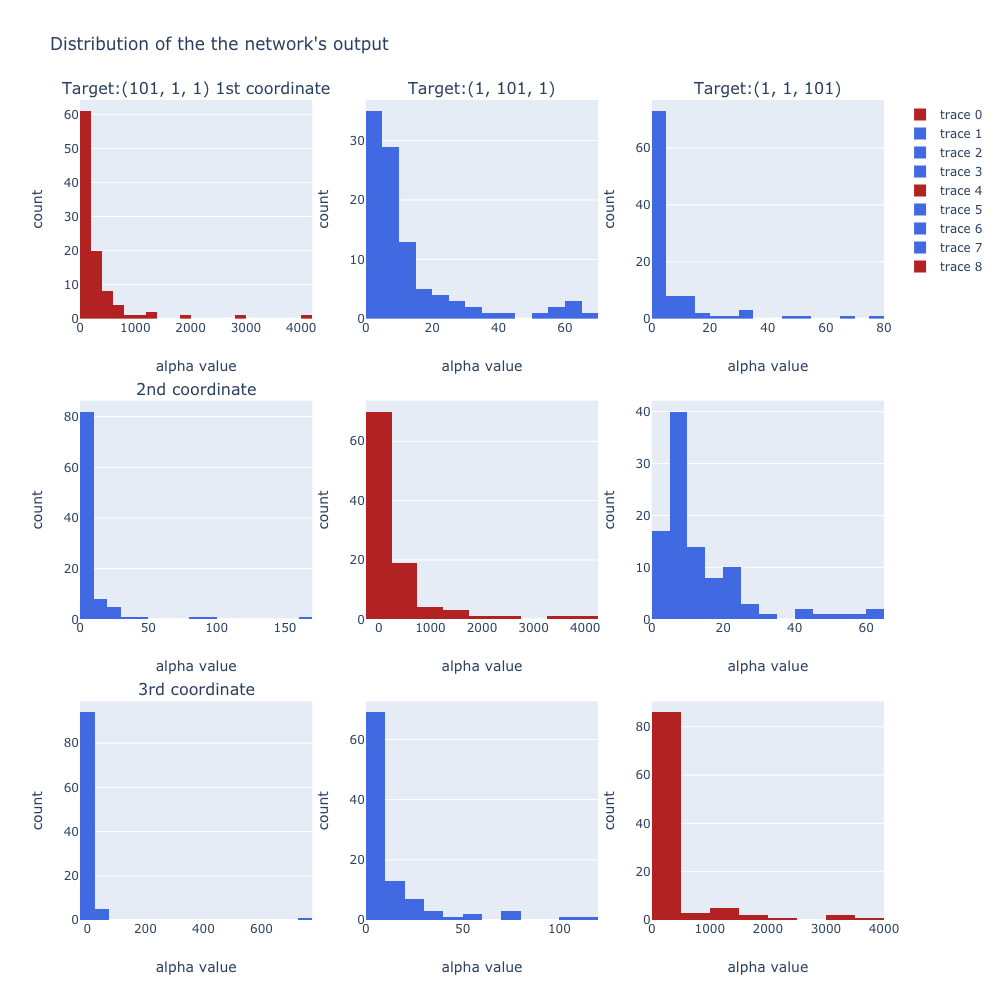

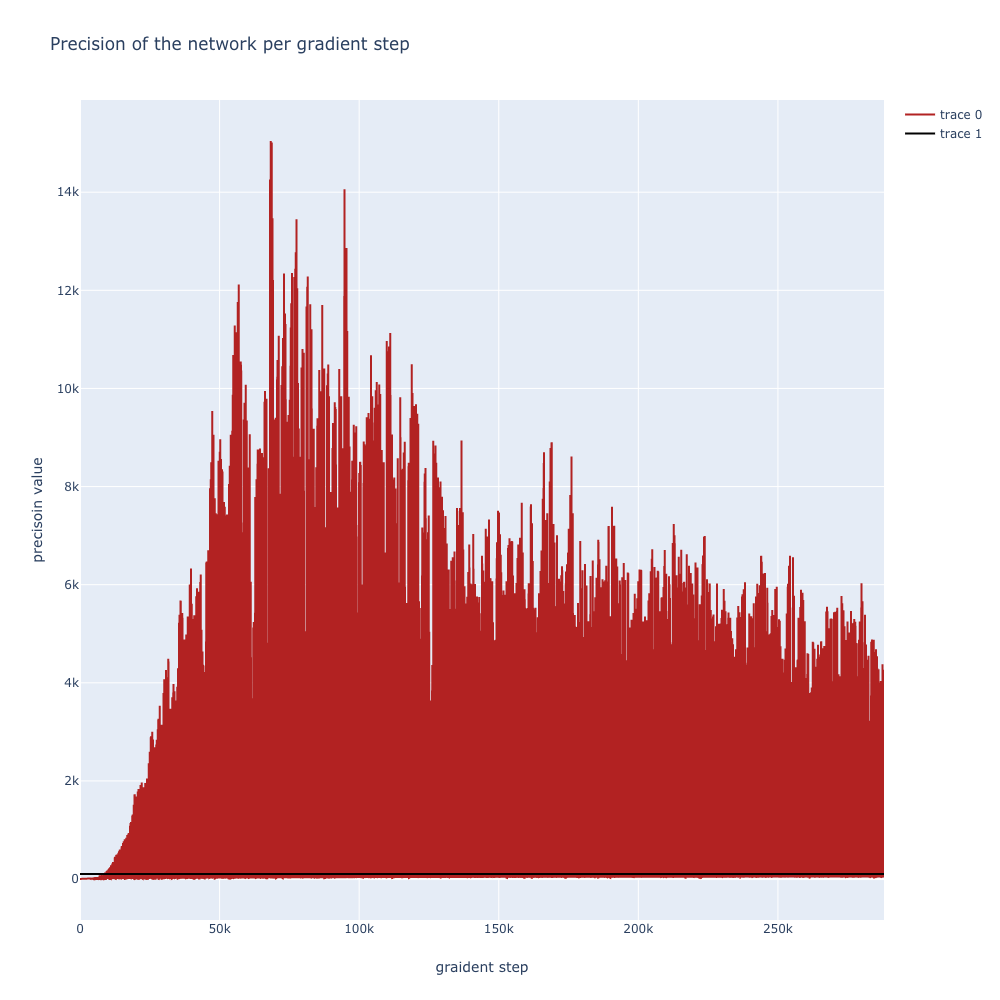

In [56]:
args.n_epochs = 1000
args.reverse = True
print(args)
model_rev ,tracks_rev  = main(args,data)

The two training losses displayed have oscillating patterns and it seems that there is a trend towards convergence. The oscillations of the "RKL network" are nevertheless more important than the ones from the "KL" which looks smoother. 
Intuitively, we hypothesize that the KL model makes "smaller errors". However, it could also mean that even when points are in *an overlapping area* (at the center of the grid for instance), the model outputs values that are less extreme and centered around the right mode.

- **With the KL objective**: the output of the network during the training process look (relatively) similar to the ones obtained in **section I**, with the "right order of magnitude" (trace plots of the network's output). The inference step provides distributions relatively close to the target one: the non-diagonal histograms plots are in a $0-2$ range and the diagonal plots diplay a distribution centered around higher values. 

- **With the RKL objective**: the loss and trace plots are highly oscillating and the non-diagonal terms of the histograms now appear on a $0-500$ while the diagonal terms range from 0 to several thousands. All the traces are pushed towards higher values. We might naively diagnose a poor training behavior.

One question arises: would we expect or want the network to have a similar training curriculum (and henceforth a similar inference behavior) when the data is that different ? 
Let's consider a point $x \in \mathbb{R}^2$ in one area where the data is overlapping, for instance $x = (0,0)$ (as a proxy for the region where the data is highly overlapping). 

Let's recall that $\alpha = f(x;\theta)$ represents the concentration parameter of a (3 dimensional) Dirichlet distribution, defined on the 3d simplex (its behavior can and is most of the time visualized on a simplex). In the case of high overlap, the desiderata would be to obtain a Dirichlet ditribution $p(\mu|x, \hat{\theta})$ centered on the center of the simplex.

With the observations above, we hypothesize the following: 
* the KL training objective and the overparametrization of the network result in a distribution $p(\mu|x, \hat{\theta})$ that spreads accross the boundaries of the simples, making the errors small. This is due to the target distribution which is, in that region of $\mathbb{R}^2$, a mixture of the three Dirichlet with parameters $target_1, target_2, target_3$ respectively and therefore presents three modes in each corner of the simplex.
* the RKL objective avoids this "problem" by inducing a target that is unimodal and rather than spreading its mass, the approximation centers around an other area, making "bigger errors".

Remarks:
* *For a reminder about the Dirichlet distribution [(CMU) Professor Xing's notes](https://www.cs.cmu.edu/~epxing/Class/10701-08s/recitation/dirichlet.pdf) is an excellent resource*. 

* Desired behavior of a prior network:
> when it is confident in its prediction a Prior Network should yield a sharp distribution centered on one of the corners of the simplex. For an input in a region with high degrees of noise or class overlap (data uncertainty) a Prior Networkshould yield a sharp distribution focused on the center of the simplex, which corresponds to being
confident in predicting a flat categorical distribution over class labels (known-unknown).


## 2. Theoretical behavior
The following section is adapted from "_Reverse KL-Divergence Training of Prior Networks:
Improved Uncertainty and Adversarial Robustness_" [(arxiv)](https://arxiv.org/pdf/1905.13472.pdf)

Let us define the **forward KL objective**: $$l(\theta, y, x) = \sum_{c=1}^{K} \mathbb{1}_{y=c} KL(p(\mu|\alpha_x) || p(\mu|f(x;\theta))$$

We denote $\hat{p}(x,y)$ the empirical distribution of the data and we now consider the expectation of the loss with respect to this empirical distribution:
$$\mathbb{E}_{\hat p}[l(\theta, y, x)] = \mathbb{E}_{\hat p} [KL( \sum_{c=1}^{K} \hat{p}(x,y) p(\mu|\alpha_x) || p(\mu|f(x;\theta))] + constant$$

Therefore, in expectation, the target is a mixture of K(=3) Dirichlet distributions which has modes (3) in each corner of the simplex (see plot below). 
Furthermore, the forward KL is known as **zero avoiding** and whenever $p(x)>0$, $q(x)\approx 0$ would give a term $\frac{p(x)}{q(x)}$ highly penalizing the loss. Therefore, the KL objective urges the prior network distribution to spread its mass accross all the modes, "effectively inverting the Dirichlet distribution and forcing the precision term to zero". 

On the other hand, in expectation, the reverse KL objective leads the model to approximate am arithmetic mixture of Dirichlet distributions: 
Let the **reverse KL objective** be: $$l^{DKL}(\theta, y, x) = \sum_{c=1}^{K} \mathbb{1}_{y=c} KL( p(\mu|f(x;\theta) || p(\mu|\alpha_x))$$

$$\mathbb{E}_{\hat p}[l^{DKL}(\theta, y, x)] = \sum_{c=1}^{K} \hat{p}(x,y) KL( p(\mu|f(x;\theta) || p(\mu|\alpha_x))
= finish equations
$$

In short, the training objective is now, in expectation, a uni-modal distribution with a concentration parameter being a mixture of three parameters. Where there is data overlap, the target distribution pushes the model to approximate a distribution focused on the center of the simplex. 

Remark:
* Please refer to the original paper referenced above for an extended discussion on the expected behavior of prior networks trained with KL or DKL

## 3. Observed behavior

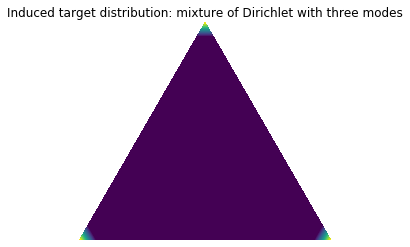

In [57]:
#Model
from utils_run import plot_dirichlet_simplex, plot_dirichlet_model
#We use 10,1,1 instead of 101,1,1 for visualization purpose
dist = [torch.distributions.Dirichlet(torch.tensor(x)) for x in ([101.,1.,1.], 
                                                                 [1.,101.,1.], 
                                                                 [1.,1.,101.])]
plot_dirichlet_simplex(dist)
plt.title("Induced target distribution: mixture of Dirichlet with three modes")
plt.show()

In [62]:
#What are the values at point (0,0)?
x = torch.tensor([0.0,0.0]).reshape(1,-1)
#x = torch.tensor([-0.023,0.048]).reshape(1,-1)
_,_,alph_out_fwd,_= model_fwd(x)
_,_,alph_out_rev,_= model_rev(x)

print("Value of the 'forward' and 'reverse' networks for the input : {}\n forward: {}\n reverse {}".format(x.tolist(), 
                                                                                                  alph_out_fwd.detach().tolist(),
                                                                                                  alph_out_rev.detach().tolist()))


Value of the 'forward' and 'reverse' networks for the input : [[-0.023000000044703484, 0.04800000041723251]]
 forward: [[0.1598684936761856, 0.1743241250514984, 0.16554978489875793]]
 reverse [[7.149764537811279, 15.611766815185547, 11.757946014404297]]


Even if the term $f^{reverse}(x;\theta)$ slightly leans towards one mode more than the two others, we experimentally observe relatively sharp outputs that are well-balanced, whereas $f^{forward}(x;\theta)$ consists in three parameters close to $0$ which would yield a distribution spread accross the three corners of a simplex. To further support this point, we present a heatmap of the pdf of $p(\mu|f^{reverse}(x;\theta))$ and $p(\mu|f^{forward}(x;\theta))$.

Rather than considering $x =(0,0)$, we generate a noise (for visualization purpose) by taking $x \in B(0;\epsilon)$ as $\int_{B(0;\epsilon)} p(\mu|f(x;\theta))dx \approx p(\mu|f(0;\theta))$.


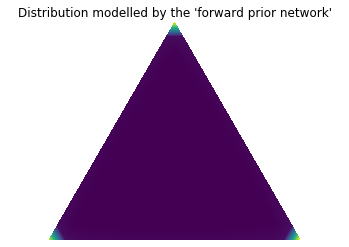

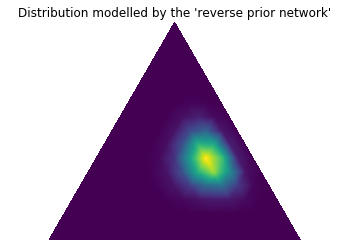

In [61]:
#plt.show()
#What if we take a point in the verry middle ??
#x = torch.tensor([0.,0.]).reshape(1,-1)
#x.shape
#print("FORWARD")
#_,_,alph_out,_ = model_fwd(x)
#alph_out = alph_out.detach()
#plot_dirichlet_simplex([torch.distributions.Dirichlet(alph_out)])
#plt.show()

#print("REVERSE")
#_,_,alph_out,_ = model_rev(x)
#alph_out = alph_out.detach()
#plot_dirichlet_simplex([torch.distributions.Dirichlet(alph_out)])
#plt.show()
#=================================
# Grid
#=================================
possible_vals = np.linspace(-0.05, 0.05, 81)
x_vals, y_vals = np.meshgrid(possible_vals, possible_vals)
grid_inputs = torch.tensor(np.stack((x_vals.flatten(), y_vals.flatten()), axis=1), dtype=torch.float32)
#print("FORWARD")
_,_,alph_out,_ = model_fwd(grid_inputs)
alph_out = alph_out.detach()
mixture = [torch.distributions.Dirichlet(alph_out[i]) for i in range(len(alph_out))]
plot_dirichlet_simplex(mixture, nlevels=1000)
plt.title("Distribution modelled by the 'forward prior network'")
plt.show()

#print("REVERSE")
_,_,alph_out,_ = model_rev(grid_inputs)
alph_out = alph_out.detach()
mixture = [torch.distributions.Dirichlet(alph_out[i]) for i in range(len(alph_out))]
plot_dirichlet_simplex(mixture, nlevels=1000)
plt.title("Distribution modelled by the 'reverse prior network'")
plt.show()


In the light of the above results, we interpret the results of **II-1**:?


# TODO
-Clean the plots.

-Make Rylan proofread.

- Restructure exp_alphas.py to have work with the utils/run structure.

One more thing:
"This work addresses the explicit prediction of each of the three types of predictive uncertainty by extending the work done in [21, 22] while taking inspiration from Bayesian approaches."

All of the Bayesian approach is breaken down when he does the frequentist assumption that:
"Unfortunately, like eq. 1, the marginalization in eq. 6 is generally intractable, though it can be
approximated via Bayesian MC methods. For simplicity, this work will assume that a point-estimate
(eq. 7) of the parameters will be sufficient given appropriate regularization and training data size.
p(✓|D) = (✓  ✓
ˆ) =) p(µ|x⇤; D) ⇡ p(µ|x⇤; ✓
ˆ) "

**Dirty comments**
Two comments:
* 1: _About the training:_ The reverse KL training seems to yield senseical results. Even though the loss is noisy and the oscilattions are important, still, the networks "learns" that: cor a given point, the Dirichlet target distribution is made of three different Dirichlet weights, one being on a much bigger scale. Indeed, the 'red curves' appear to be on a scale approximately 100 times bigger than the other two ones. 
* Similarly, the forward KL yields some scaled Dirichelt parameters, but even thesupposedly smallest parameters 


However, we migth still wonder what "is the right behavior in this context" ? 
In the first case, we also observe one period of extreme unstability during the training, which is unimportant sfter appropriate burn-in but is with nothing. Furthermore, the "Network's output Dirichlet" (id est the conditional Dirichlet distribution modelled by the network) is sharp. One might want a sharp DIrichlet at the very middle point of a simplex, but this approach can be criticized as well. 

* 2: _About the modelled Dirichlet distribution_: 


## UNIMPORTANT-DIRTY 

In [ ]:
import matplotlib.pyplot as plt
plt.show()
%run -i 'exp_alphas_2.py'
plt.show()

In [ ]:
args.n_epochs = 100
model, tracks = main(args,data)

In [ ]:
from utils_run import plot_dirichlet_simplex, plot_dirichlet_model
dist = [torch.distributions.Dirichlet(torch.tensor(x)) for x in ([101.,1.,1.], 
                                                                 [1.,101.,1.], 
                                                                 [1.,1.,101.])]
plot_dirichlet_simplex(dist)
plt.show()

    
plot_dirichlet_model(model, data)
plt.show()
#induced behavior

In [ ]:
#Let's consider the output of the network for the entire dataset
#model.eval()
#Observed behavior

In [ ]:
"""#Choice 1: vectorize
#refiner = tri.UniformTriRefiner(triangle)
#trimesh = refiner.refine_triangulation(subdiv=8)
#barycentric_points = list(xy2bc(xy, corners, midpoints) for xy in zip(trimesh.x, trimesh.y))

N = len(barycentric_points)
#bary_centric_points = np.zeros((153, d.concentration.shape[0], d.concentration.shape[1])
#                              ) + np.expand_dims(np.array(barycentric_points), axis=1)#broadcast -> N,bs,3
try:
    bary_centric_points = torch.zeros((N, dist.concentration.shape[0], dist.concentration.shape[1])
                             ) + torch.tensor(barycentric_points).unsqueeze(1)#broadcast -> N,bs,3
except:
    #bary_centric_points =t orch.zeros((N, dist.concentration.shape[0])
    #                         ) + torch.tensor(barycentric_points)#broadcast -> N,bs,3
    bary_centric_points = torch.tensor(barycentric_points)
#np.array(barycentric_points)
#bary_centric_points[2]
#d.log_prob(torch.tensor(bary_centric_points))
torch.tensor(bary_centric_points)
out = dist.log_prob(torch.tensor(bary_centric_points))
#pvals = out.sum(axis=1)
pvals=out.clone()
print(pvals)

plt.tricontourf(trimesh, pvals, 400)
plt.axis('equal')
plt.xlim(0, 1)
plt.ylim(0, 0.75**0.5)
plt.axis('off')
"""